## Exercise 5. Create a Dataset from GEOJSON
Let's use [Socrata-py](https://github.com/socrata/socrata-py#geojson) to add more information to our dataset.

## Import Libraries

In [32]:
%matplotlib inline

import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd

from shapely import geometry, wkt

from socrata.authorization import Authorization
from socrata import Socrata

## Setup Authentication
- Can enter Socrata user name and password or api keys with key id and secret values respectively
- Enter the domain of dataset if you have publisher or admin access

In [33]:
user_name = os.environ['MY_SOCRATA_USERNAME']
password = os.environ['MY_SOCRATA_PASSWORD']
domain = 'alicia.data.socrata.com'

auth = Authorization(
  domain,
  user_name,
  password
)

socrata = Socrata(auth)

## Select Shape file to convert to GEOJSON
Let's use the Census Cartographic Boundary file for 2017 Arizona Places downloaded from https://www.census.gov/geo/maps-data/data/cbf/cbf_place.html for Arizona (http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_04_place_500k.zip)

  STATEFP PLACEFP   PLACENS          AFFGEOID    GEOID          NAME LSAD  \
0      04   66820  02411898  1600000US0466820  0466820  Sierra Vista   25   
1      04   58010  02412516  1600000US0458010  0458010    Quartzsite   43   
2      04   54050  02411401  1600000US0454050  0454050        Peoria   25   
3      04   74190  02412078  1600000US0474190  0474190      Tolleson   25   
4      04   04720  02409765  1600000US0404720  0404720      Avondale   25   

       ALAND   AWATER                                           geometry  
0  394277573   678788  POLYGON ((-110.449149 31.550338, -110.447924 3...  
1   94008865        0  POLYGON ((-114.269818 33.710637, -114.217028 3...  
2  455061591  8825426  (POLYGON ((-112.211145 33.619523, -112.208488 ...  
3   14943015        0  POLYGON ((-112.289902 33.449935, -112.281021 3...  
4  117194454   186352  (POLYGON ((-112.292384 33.417304, -112.289632 ...  


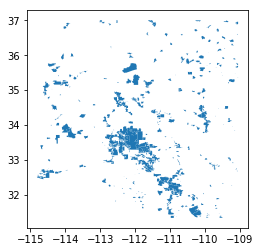

In [34]:
census_cb = gpd.read_file("../data/cb_2017_04_place_500k/cb_2017_04_place_500k.shp")
print(census_cb.head())

# plot the polygons!
census_cb.plot()

## Convert Polygons to Multipolygons

In [35]:
#Handy function provided by https://github.com/geopandas/geopandas/issues/834
upcast_dispatch = {geometry.Point: geometry.MultiPoint, 
                   geometry.LineString: geometry.MultiLineString, 
                   geometry.Polygon: geometry.MultiPolygon}

def maybe_cast_to_multigeometry(geom):
    caster = upcast_dispatch.get(type(geom), lambda x: x[0])
    return caster([geom])

census_cb.geometry = census_cb.geometry.apply(maybe_cast_to_multigeometry)

file_name = '../data/cb_2017_04_place_500k.json'

# Convert to GEOJSON
census_cb.to_file(file_name, driver='GeoJSON')

/usr/local/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


## Create dataset from GEOJSON

In [36]:
dataset_name = 'Arizona Cartographic Boundary Shapefiles - Places (Incorporated Places and Census Designated Places)'
dataset_description = 'The cartographic boundary files are simplified representations of selected geographic areas from the Census Bureau’s MAF/TIGER geographic database. These boundary files are specifically designed for small scale thematic mapping.'

# This is our socrata object, using the auth variable from above
socrata = Socrata(auth)

# This will make our initial revision, on a view that doesn't yet exist
(ok, rev) = socrata.new({'name': dataset_name, 'description': dataset_description})
assert ok

# Using that revision, we can create an upload
(ok, upload) = rev.create_upload('foo.json')
assert ok

# And using that upload we just created, we can put bytes into it
with open(file_name, 'rb') as f:
        (ok, source) = upload.geojson(f)
        assert ok
        
# TODO: create revision to rename geometry to the_geom
        
# Apply the revision - this will make it public
(ok, job) = rev.apply()

# Now we can get the unique dataset id
dataset_id = rev.view_id()
dataset_url = 'https://' + domain + '/d/' + dataset_id

print(dataset_url)


https://alicia.data.socrata.com/d/mxgp-dssj
